In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

In [48]:
filepath = r"C:\Users\user\Projetos\densities4risk\data\processed\database.parquet"
df = pd.read_parquet(filepath)
df_bvsp = df[df["ticker"]=="BVSP"].loc[:,["datetime", "open", "high", "low", "close"]].dropna().drop_duplicates()
df.head()

,ticker,frequency,open,high,low,close,data_extracao,datetime
0,AAVE-USD,5m,302.061310,302.061310,301.930542,301.930542,20250907121007,NaT
1,AAVE-USD,5m,301.960876,302.158112,301.960876,302.085999,20250907121007,NaT
2,AAVE-USD,5m,301.988098,301.988098,301.536377,301.574310,20250907121007,NaT
3,AAVE-USD,5m,301.527924,301.527924,301.111328,301.111328,20250907121007,NaT
4,AAVE-USD,5m,301.120209,301.120209,300.788177,300.802887,20250907121007,NaT


In [51]:
filepath = r"C:\Users\user\Projetos\densities4risk\data\raw\history.parquet"
df = pd.read_parquet(filepath)
df.reset_index().head()

,datetime,ticker,frequency,open,high,low,close,data_extracao
0,2025-07-09 21:00:00,AAVE-USD,5m,302.061310,302.061310,301.930542,301.930542,20250907121007
1,2025-07-09 21:05:00,AAVE-USD,5m,301.960876,302.158112,301.960876,302.085999,20250907121007
2,2025-07-09 21:10:00,AAVE-USD,5m,301.988098,301.988098,301.536377,301.574310,20250907121007
3,2025-07-09 21:15:00,AAVE-USD,5m,301.527924,301.527924,301.111328,301.111328,20250907121007
4,2025-07-09 21:20:00,AAVE-USD,5m,301.120209,301.120209,300.788177,300.802887,20250907121007


In [52]:
filepath = r"C:\Users\user\Projetos\densities4risk\data\raw\PETR3SA_5m_2025102100.parquet"
df = pd.read_parquet(filepath)
df.reset_index().head()

,datetime,ticker,frequency,open,high,low,close,data_extracao
0,2025-07-29 10:00:00,PETR3SA,5m,35.200001,35.270000,35.000000,35.060001,2025102100
1,2025-07-29 10:05:00,PETR3SA,5m,35.060001,35.130001,35.060001,35.060001,2025102100
2,2025-07-29 10:10:00,PETR3SA,5m,35.080002,35.119999,35.029999,35.119999,2025102100
3,2025-07-29 10:15:00,PETR3SA,5m,35.130001,35.150002,35.090000,35.119999,2025102100
4,2025-07-29 10:20:00,PETR3SA,5m,35.119999,35.169998,35.119999,35.139999,2025102100


In [42]:
df_bvsp.shape

(184943, 5)

In [43]:
df_bvsp.head(10)

,datetime,open,high,low,close
1446325,NaT,135066.968750,135066.968750,134741.546875,NaN
1446326,NaT,134728.187500,134742.421875,134694.656250,NaN
1446327,NaT,134691.796875,134978.250000,134691.796875,NaN
1446328,NaT,134933.093750,134988.953125,134722.375000,NaN
1446329,NaT,134738.875000,134820.203125,134702.437500,NaN
1446330,NaT,134689.812500,134888.218750,134689.812500,NaN
1446331,NaT,134965.125000,135275.046875,134931.125000,NaN
1446332,NaT,134908.843750,134913.734375,134691.843750,NaN
1446333,NaT,134752.156250,134752.156250,134564.687500,NaN
1446334,NaT,134612.843750,134701.812500,134612.843750,NaN


In [5]:
df_bvsp.shape

(7929, 4)

In [6]:
df_bvsp.dtypes

open     float64
high     float64
low      float64
close    float64
dtype: object

In [7]:
start_time = '10:00'
end_time = '17:00'
freq = '5T'  # 5 minutes

In [8]:
# Create a complete time index for each day
def complete_day(group):
    day = group.index[0].date()
    full_index = pd.date_range(
        f"{day} {start_time}",
        f"{day} {end_time}",
        freq=freq
    )
    return group.reindex(full_index)

In [9]:
# Apply to each day
df_complete = df_bvsp.groupby(df_bvsp.index.date, group_keys=False).apply(complete_day)

C:\Users\user\AppData\Local\Temp\ipykernel_7824\350790738.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(


In [10]:
# Reset index and rename column
df_complete = df_complete.reset_index().rename(columns={'index': 'datetime'})

In [11]:
# Added rows
df_complete.shape[0] - df_bvsp.shape[0]

146

In [12]:
df_complete.interpolate(method="linear", inplace=True)

<Figure size 1500x500 with 0 Axes>

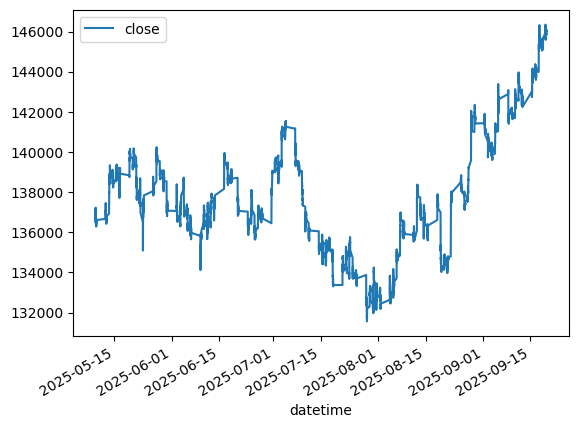

In [13]:
plt.figure(figsize=(15,5))

df_complete.plot("datetime", "close")

plt.show()

In [14]:
df_complete["R_t"] = df_complete["close"].pct_change()
df_complete["r_t"] = np.log(df_complete["close"]) - np.log(df_complete["close"].shift(1))

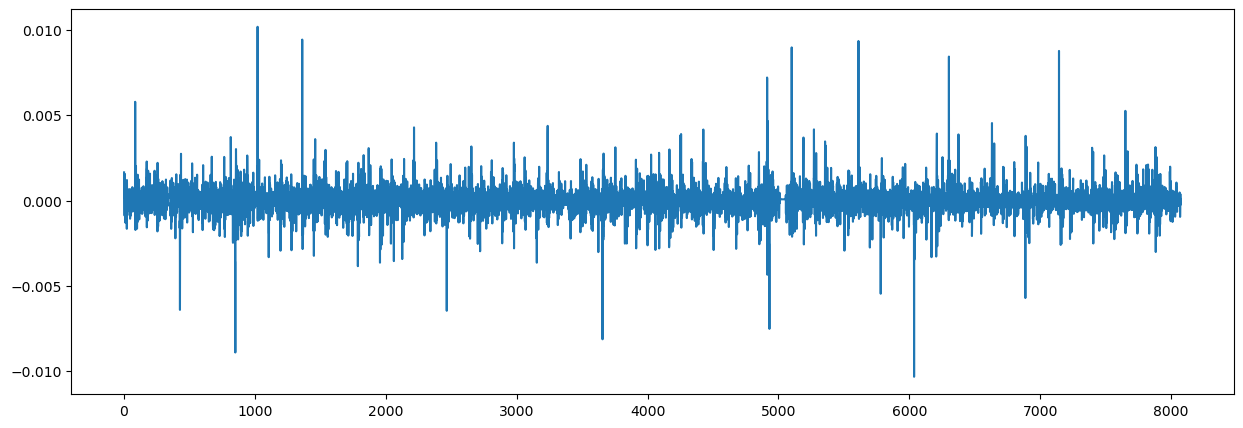

In [15]:
plt.figure(figsize=(15,5))

df_complete.r_t.plot()

plt.show()

In [16]:
bvsp = pd.Series(df_complete.r_t.values, index=df_complete.datetime)

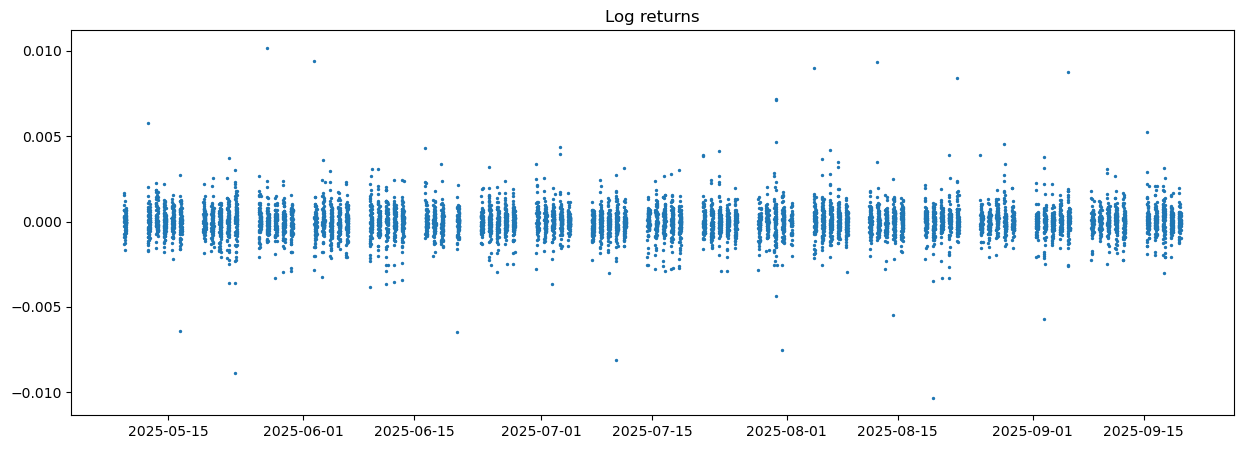

In [17]:
plt.figure(figsize=(15,5))

plt.scatter(bvsp.index, bvsp, s=2)

plt.title("Log returns")

plt.show()

In [18]:
df_complete = df_complete.dropna(subset="r_t")

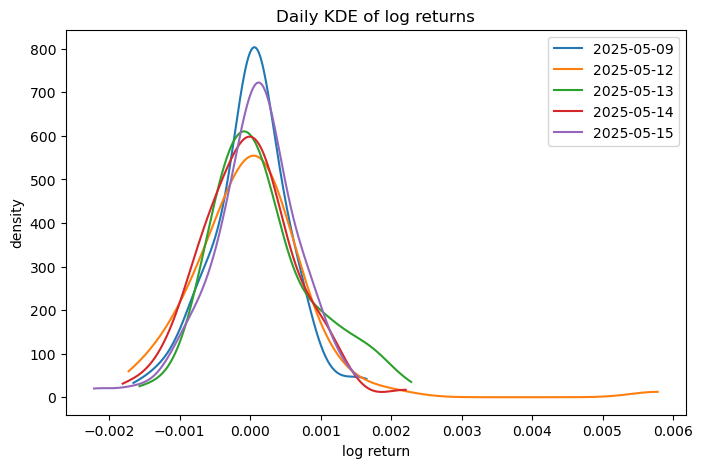

In [19]:
# Group by day
grouped = df_complete.groupby(df_complete['datetime'].dt.date)

# Compute KDE per day and store results
kde_results = {}

for day, group in grouped:
    data = group['r_t'].dropna()
    if len(data) > 1:  # need at least 2 points
        kde = gaussian_kde(data)
        # Evaluate on a grid for visualization
        x_grid = np.linspace(data.min(), data.max(), 200)
        y_kde = kde(x_grid)
        kde_results[day] = (x_grid, y_kde)

# Example: plot a few KDEs
plt.figure(figsize=(8,5))
for i, (day, (x, y)) in enumerate(kde_results.items()):
    if i >= 5:  # plot first 5 days
        break
    plt.plot(x, y, label=str(day))
plt.title('Daily KDE of log returns')
plt.xlabel('log return')
plt.ylabel('density')
plt.legend()
plt.show()

In [20]:
import plotly.graph_objects as go

In [21]:
# kde_results = {day: (x_grid, y_kde)} from previous step

# Sort days and build aligned matrices
days_sorted = sorted(kde_results.keys())

# ---- Step 1: build a common X grid (important for smooth 3D surface)
all_x = np.concatenate([kde_results[d][0] for d in days_sorted])
x_common = np.linspace(all_x.min(), all_x.max(), 200)

# ---- Step 2: evaluate each day's KDE on the common grid
Z = []
for d in days_sorted:
    kde = kde_results[d][0]
    density = kde_results[d][1]
    # Interpolate densities to common x grid
    z_interp = np.interp(x_common, kde, density)
    Z.append(z_interp)

Z = np.array(Z)
Y = np.arange(len(days_sorted))  # day index

# ---- Step 3: create 3D surface
fig = go.Figure(data=[go.Surface(
    x=x_common,   # log return values
    y=Y,          # day index
    z=Z,          # densities
    colorscale='Viridis'
)])

# ---- Step 4: layout and labels
fig.update_layout(
    title='Daily Kernel Density Estimates of Log Returns',
    scene=dict(
        xaxis_title='Log return',
        yaxis_title='Day',
        zaxis_title='Density',
        yaxis=dict(
            tickmode='array',
            tickvals=np.linspace(0, len(days_sorted)-1, 10, dtype=int),
            ticktext=[str(days_sorted[i]) for i in np.linspace(0, len(days_sorted)-1, 10, dtype=int)]
        )
    ),
    height=700
)

fig.show()